In [1]:
!pip install obspy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.2 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.30
    Uninstalling SQLAlchemy-2.0.30:
      Successfully uninstalled SQLAlchemy-2.0.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.2 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.8.2 which is incompatible.
ipython-sql 0.5.0 requires sqlalc

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
from obspy import read
from obspy import UTCDateTime
from torchinfo import summary
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import OneHotEncoder
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Set the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context("talk")



## Isolation Forest

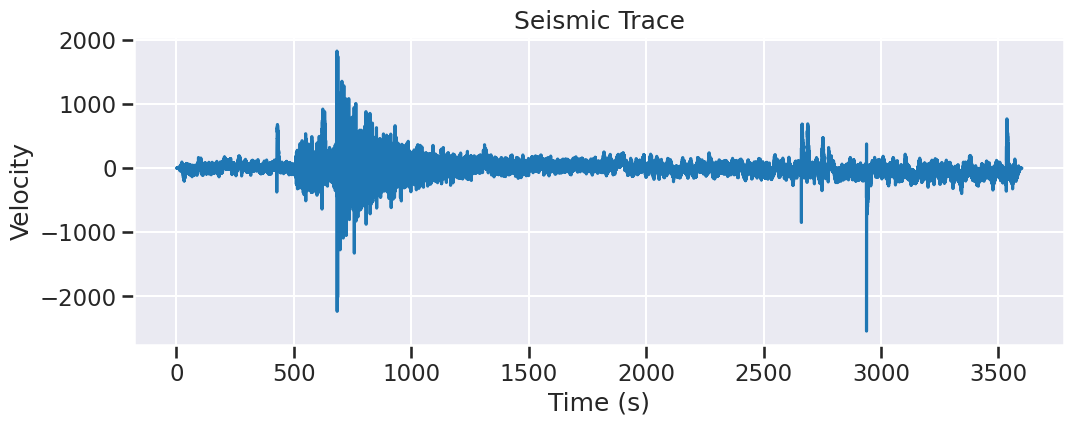

In [3]:
file_path = r'/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/mars/training/data/XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.mseed'
st = read(file_path)
tr = st[0]  # Assuming only one trace for simplicity

# Extract data and timestamps
tr_data = tr.data
tr_times = np.linspace(0, len(tr_data) / tr.stats.sampling_rate, num=len(tr_data))

plt.figure(figsize=(12, 4))
plt.plot(tr_times, tr_data)
plt.title('Seismic Trace')
plt.xlabel('Time (s)')
plt.ylabel('Velocity')
plt.show()

In [4]:
# Normalize the data (optional)
tr_data_norm = (tr_data - np.mean(tr_data)) / np.std(tr_data)

# Reshape the data for isolation forest (assuming each sample is a separate point)
data_points = tr_data_norm.reshape(-1, 1)

In [5]:
# Initialize Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)

# Fit the model on seismic data
iso_forest.fit(data_points)

# Predict anomalies
anomalies = iso_forest.predict(data_points)

# Label anomalies as -1 and normal data as 1
anomalies_indices = np.where(anomalies == -1)[0]


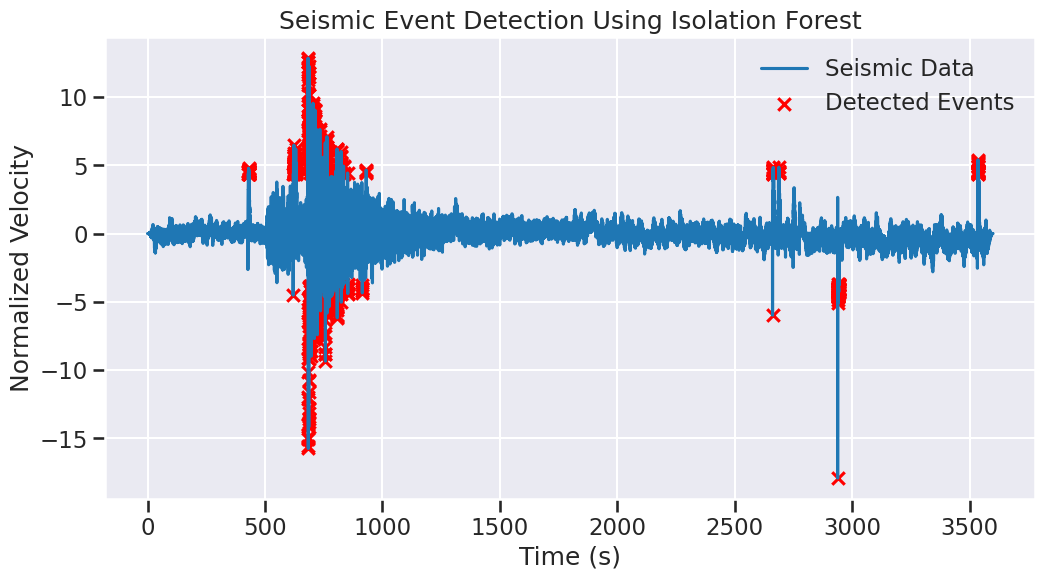

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(tr_times, tr_data_norm, label='Seismic Data')
plt.scatter(tr_times[anomalies_indices], tr_data_norm[anomalies_indices], color='red', label='Detected Events', marker='x')
plt.title('Seismic Event Detection Using Isolation Forest')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Velocity')
plt.legend()
plt.show()

# Optionally, print the times where anomalies were detected
event_times = tr_times[anomalies_indices]
#print("Seismic events detected at times (s):", event_times)

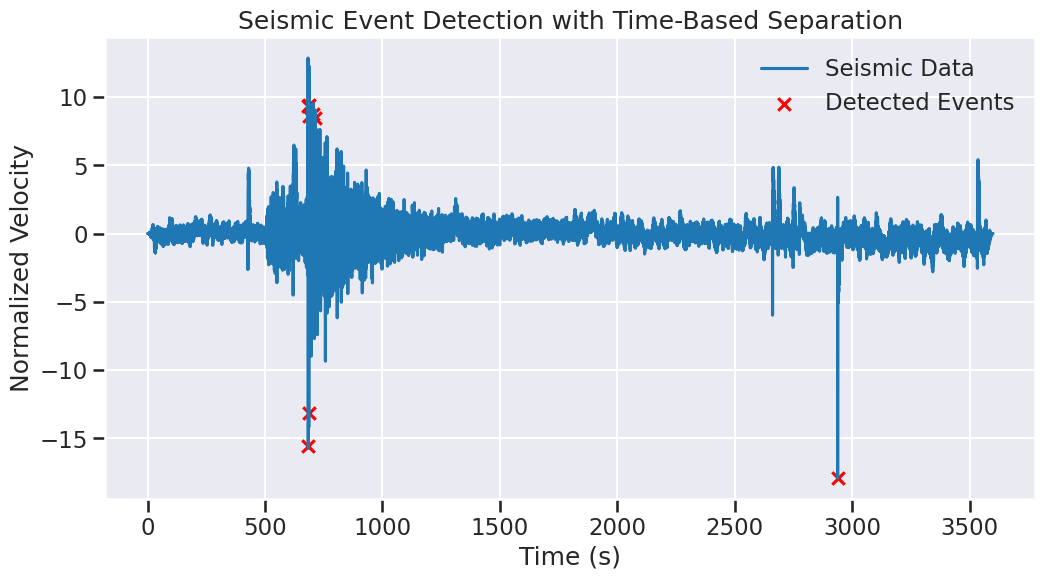

In [7]:
file_path = r'/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/mars/training/data/XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.mseed'
st = read(file_path)
tr = st[0]  # Assuming only one trace for simplicity

# Extract data and timestamps
tr_data = tr.data
tr_times = np.linspace(0, len(tr_data) / tr.stats.sampling_rate, num=len(tr_data))

# Normalize the data (optional)
tr_data_norm = (tr_data - np.mean(tr_data)) / np.std(tr_data)

# Reshape the data for isolation forest (assuming each sample is a separate point)
data_points = tr_data_norm.reshape(-1, 1)

# Initialize Isolation Forest
iso_forest = IsolationForest(contamination=0.0007, random_state=42)

# Fit the model on seismic data
iso_forest.fit(data_points)

# Predict anomalies
anomalies = iso_forest.predict(data_points)

# Label anomalies as -1 and normal data as 1
anomalies_indices = np.where(anomalies == -1)[0]

# Threshold for event separation (in seconds)
min_separation_time = 1  # adjust this value based on your data's timescale
last_event_time = -np.inf  # initialize to negative infinity

filtered_anomalies_indices = []
for idx in anomalies_indices:
    if tr_times[idx] - last_event_time > min_separation_time:
        filtered_anomalies_indices.append(idx)
        last_event_time = tr_times[idx]  # update the last event time

filtered_anomalies_indices = np.array(filtered_anomalies_indices)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(tr_times, tr_data_norm, label='Seismic Data')
plt.scatter(tr_times[filtered_anomalies_indices], tr_data_norm[filtered_anomalies_indices], color='red', label='Detected Events', marker='x')
plt.title('Seismic Event Detection with Time-Based Separation')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Velocity')
plt.legend()
plt.show()

# Optionally, print the times where filtered anomalies were detected
event_times = tr_times[filtered_anomalies_indices]
#print("Filtered seismic events detected at times (s):", event_times)

Text(0, 0.5, 'Characteristic function')

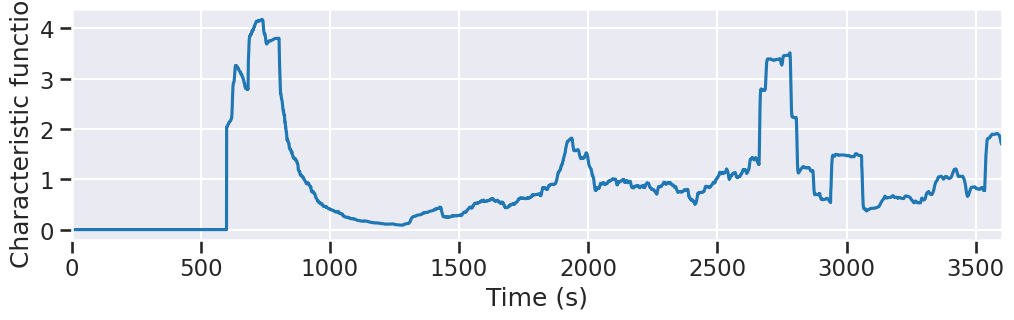

In [8]:
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

# Sampling frequency of our trace
df = tr.stats.sampling_rate

# How long should the short-term and long-term window be, in seconds?
sta_len = 120
lta_len = 600

# Run Obspy's STA/LTA to obtain a characteristic function
# This function basically calculates the ratio of amplitude between the short-term 
# and long-term windows, moving consecutively in time across the data
cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))

# Plot characteristic function
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,cft)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')

Event detected at 704.6597869414853


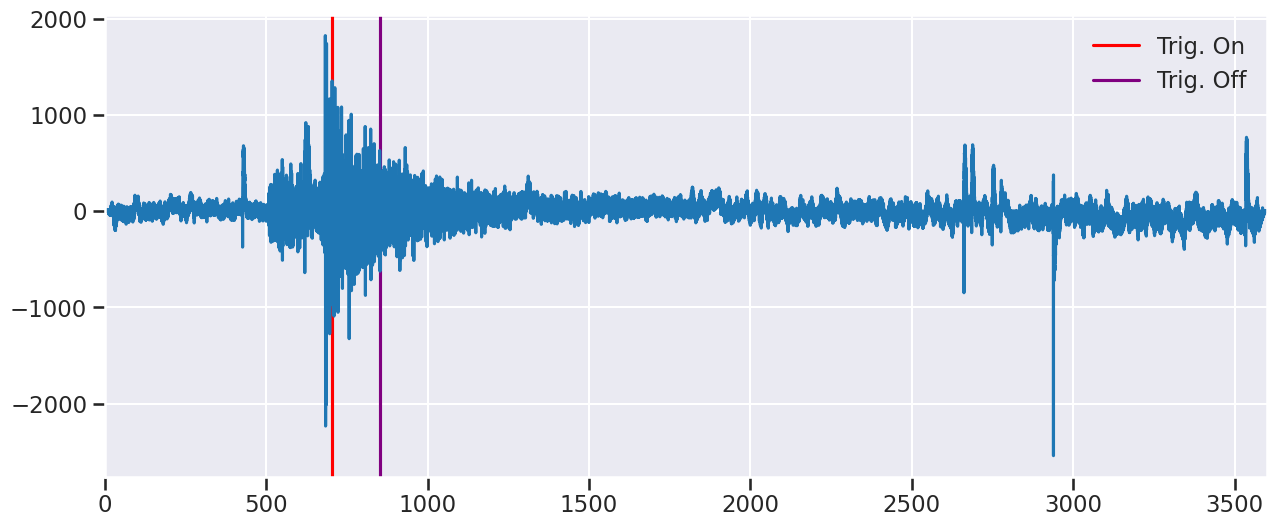

In [9]:
# Play around with the on and off triggers, based on values in the characteristic function
thr_on = 4
thr_off = 1.5
on_off = np.array(trigger_onset(cft, thr_on, thr_off))
# The first column contains the indices where the trigger is turned "on". 
# The second column contains the indices where the trigger is turned "off".

# Plot on and off triggers
fig,ax = plt.subplots(1,1,figsize=(15,6))
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    ax.axvline(x = tr_times[triggers[0]], color='red', label='Trig. On')
    print(f'Event detected at {tr_times[triggers[0]]}')
    ax.axvline(x = tr_times[triggers[1]], color='purple', label='Trig. Off')

# Plot seismogram
ax.plot(tr_times,tr_data)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.legend()

## Test evid0006 (second training file)

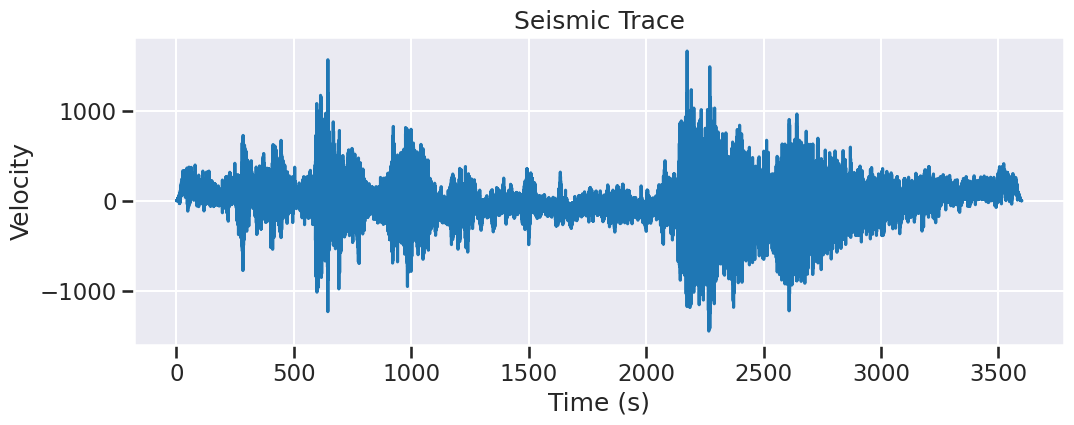

Text(0, 0.5, 'Characteristic function')

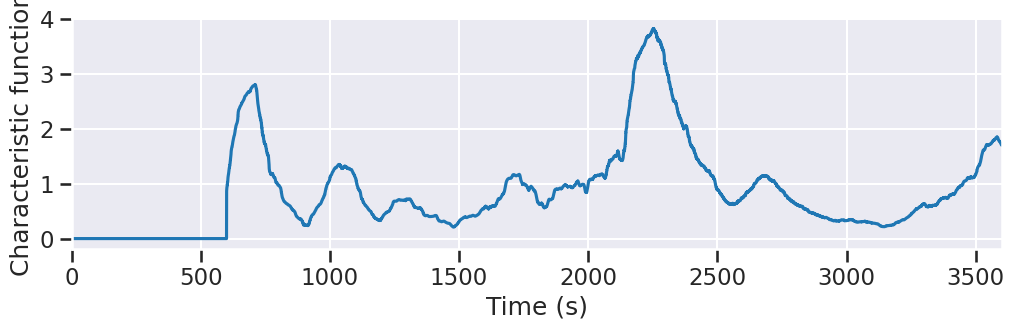

In [10]:
file_path = r'/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/mars/training/data/XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.mseed'
st = read(file_path)
tr = st[0] 
tr_data = tr.data
tr_times = np.linspace(0, len(tr_data) / tr.stats.sampling_rate, num=len(tr_data))

plt.figure(figsize=(12, 4))
plt.plot(tr_times, tr_data)
plt.title('Seismic Trace')
plt.xlabel('Time (s)')
plt.ylabel('Velocity')
plt.show()
df = tr.stats.sampling_rate
sta_len = 120
lta_len = 600
cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,cft)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')


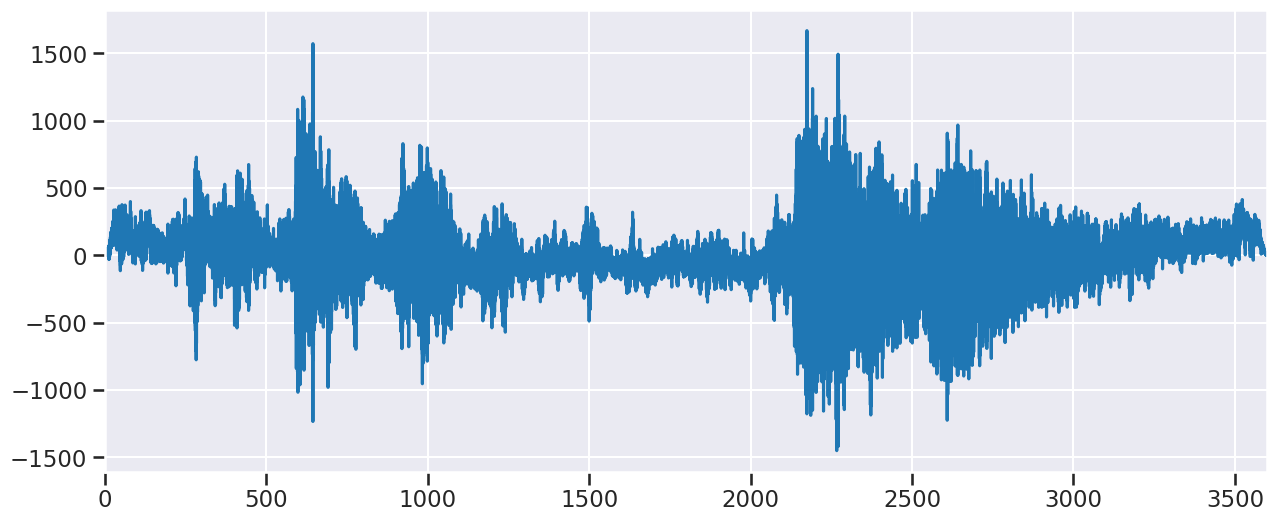

In [11]:
thr_on = 4
thr_off = 1.5
on_off = np.array(trigger_onset(cft, thr_on, thr_off))
fig,ax = plt.subplots(1,1,figsize=(15,6))
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    ax.axvline(x = tr_times[triggers[0]], color='red', label='Trig. On')
    print(f'Event detected at {tr_times[triggers[0]]}')
    ax.axvline(x = tr_times[triggers[1]], color='purple', label='Trig. Off')
ax.plot(tr_times,tr_data)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.legend()

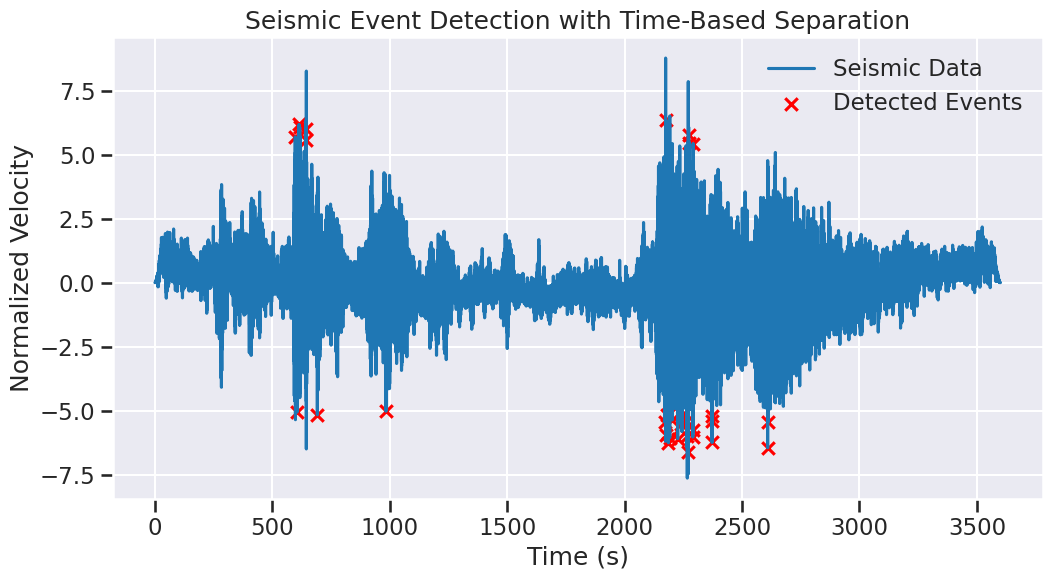

In [12]:
file_path = r'/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/mars/training/data/XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.mseed'
st = read(file_path)
tr = st[0]  # Assuming only one trace for simplicity

# Extract data and timestamps
tr_data = tr.data
tr_times = np.linspace(0, len(tr_data) / tr.stats.sampling_rate, num=len(tr_data))

# Normalize the data (optional)
tr_data_norm = (tr_data - np.mean(tr_data)) / np.std(tr_data)

# Reshape the data for isolation forest (assuming each sample is a separate point)
data_points = tr_data_norm.reshape(-1, 1)

# Initialize Isolation Forest
iso_forest = IsolationForest(contamination=0.001, random_state=42)

# Fit the model on seismic data
iso_forest.fit(data_points)

# Predict anomalies
anomalies = iso_forest.predict(data_points)

# Label anomalies as -1 and normal data as 1
anomalies_indices = np.where(anomalies == -1)[0]

# Threshold for event separation (in seconds)
min_separation_time = 1  # adjust this value based on your data's timescale
last_event_time = -np.inf  # initialize to negative infinity

filtered_anomalies_indices = []
for idx in anomalies_indices:
    if tr_times[idx] - last_event_time > min_separation_time:
        filtered_anomalies_indices.append(idx)
        last_event_time = tr_times[idx]  # update the last event time

filtered_anomalies_indices = np.array(filtered_anomalies_indices)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(tr_times, tr_data_norm, label='Seismic Data')
plt.scatter(tr_times[filtered_anomalies_indices], tr_data_norm[filtered_anomalies_indices], color='red', label='Detected Events', marker='x')
plt.title('Seismic Event Detection with Time-Based Separation')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Velocity')
plt.legend()
plt.show()

# Optionally, print the times where filtered anomalies were detected
event_times = tr_times[filtered_anomalies_indices]
#print("Filtered seismic events detected at times (s):", event_times)

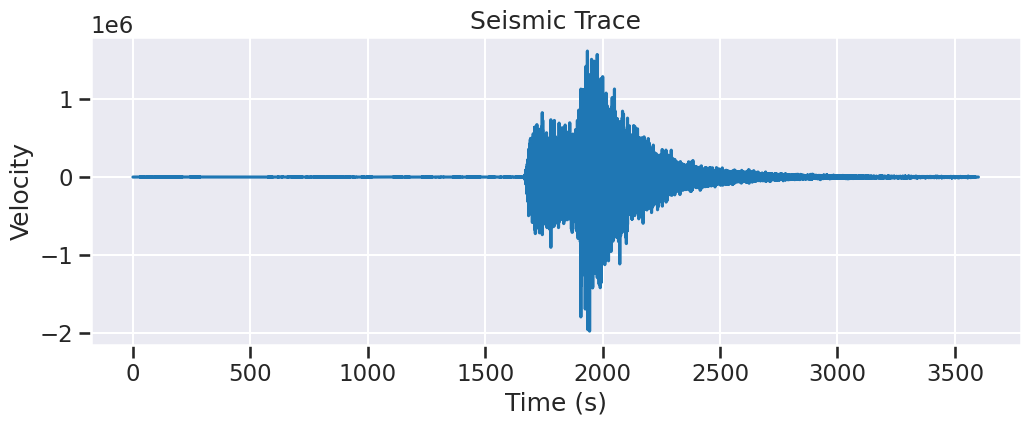

Text(0, 0.5, 'Characteristic function')

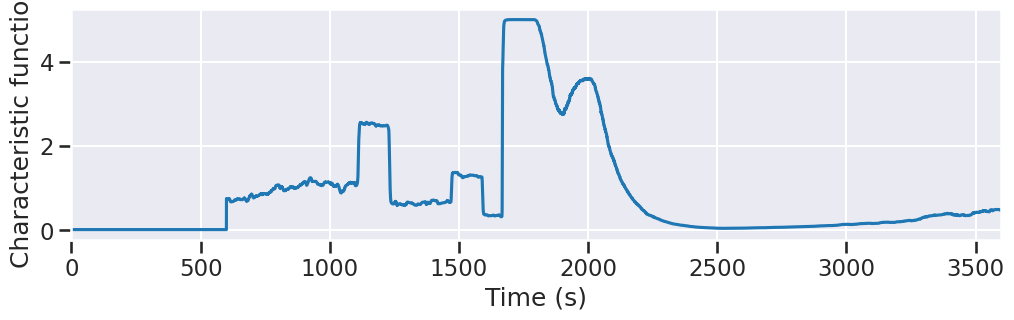

In [13]:
file_path = r'/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/mars/test/data/XB.ELYSE.02.BHV.2022-05-04HR23_evid0001.mseed'
st = read(file_path)
tr = st[0] 
tr_data = tr.data
tr_times = np.linspace(0, len(tr_data) / tr.stats.sampling_rate, num=len(tr_data))

plt.figure(figsize=(12, 4))
plt.plot(tr_times, tr_data)
plt.title('Seismic Trace')
plt.xlabel('Time (s)')
plt.ylabel('Velocity')
plt.show()
df = tr.stats.sampling_rate
sta_len = 120
lta_len = 600
cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,cft)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')


Event detected at 1668.5231742548403


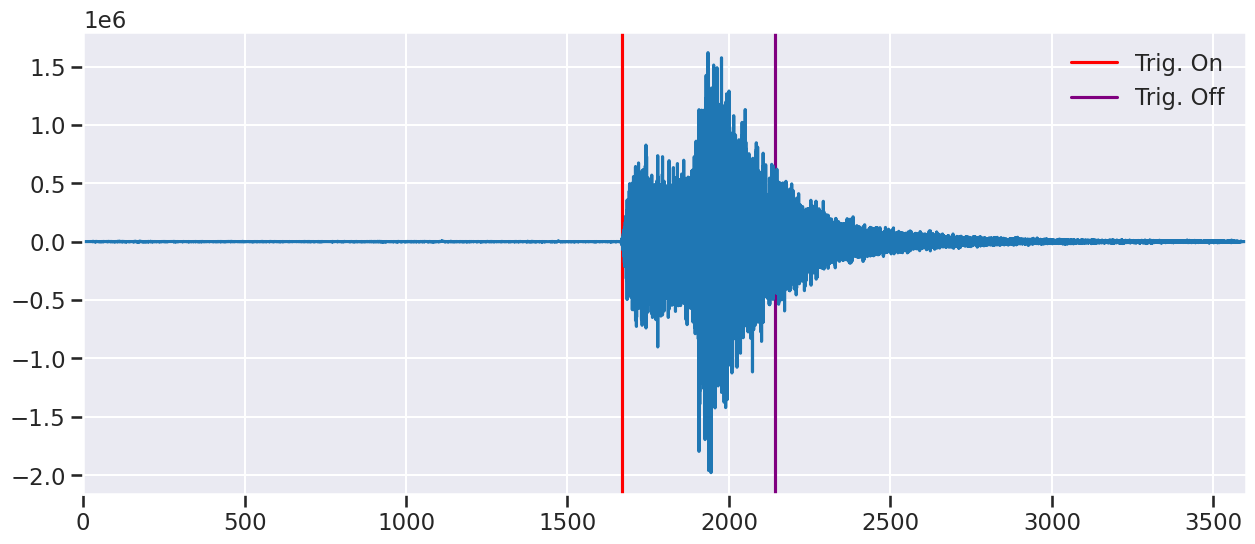

In [14]:
thr_on = 3
thr_off = 1
on_off = np.array(trigger_onset(cft, thr_on, thr_off))
fig,ax = plt.subplots(1,1,figsize=(15,6))
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    ax.axvline(x = tr_times[triggers[0]], color='red', label='Trig. On')
    print(f'Event detected at {tr_times[triggers[0]]}')
    ax.axvline(x = tr_times[triggers[1]], color='purple', label='Trig. Off')
ax.plot(tr_times,tr_data)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.legend()

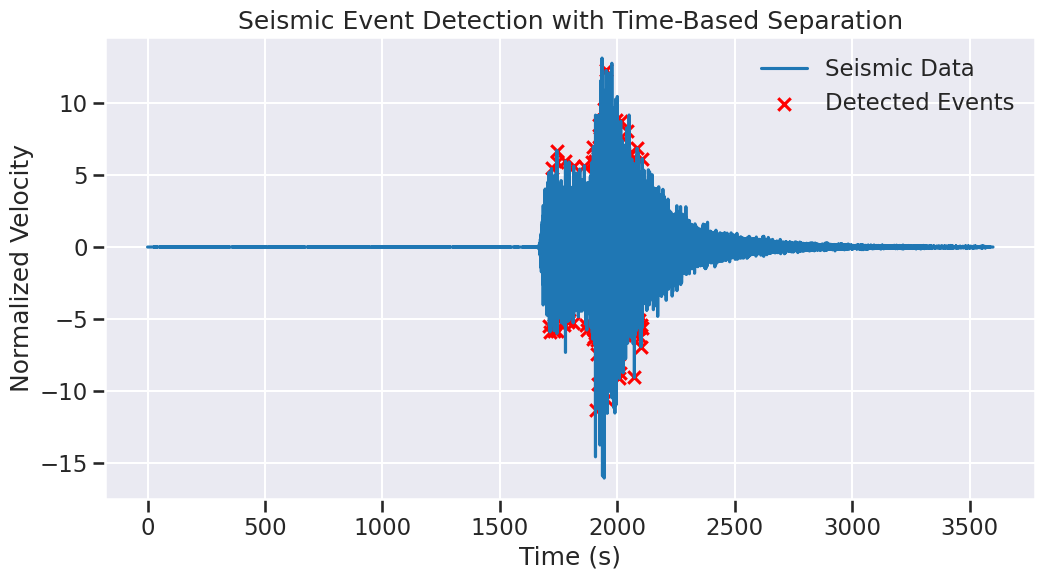

In [15]:
file_path = r'/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/mars/test/data/XB.ELYSE.02.BHV.2022-05-04HR23_evid0001.mseed'
st = read(file_path)
tr = st[0]  # Assuming only one trace for simplicity

# Extract data and timestamps
tr_data = tr.data
tr_times = np.linspace(0, len(tr_data) / tr.stats.sampling_rate, num=len(tr_data))

# Normalize the data (optional)
tr_data_norm = (tr_data - np.mean(tr_data)) / np.std(tr_data)

# Reshape the data for isolation forest (assuming each sample is a separate point)
data_points = tr_data_norm.reshape(-1, 1)

# Initialize Isolation Forest
#iso_forest = IsolationForest(contamination=0.0007, random_state=42)

# Fit the model on seismic data
#iso_forest.fit(data_points)

# Predict anomalies
anomalies = iso_forest.predict(data_points)

# Label anomalies as -1 and normal data as 1
anomalies_indices = np.where(anomalies == -1)[0]

# Threshold for event separation (in seconds)
min_separation_time = 1  # adjust this value based on your data's timescale
last_event_time = -np.inf  # initialize to negative infinity

filtered_anomalies_indices = []
for idx in anomalies_indices:
    if tr_times[idx] - last_event_time > min_separation_time:
        filtered_anomalies_indices.append(idx)
        last_event_time = tr_times[idx]  # update the last event time

filtered_anomalies_indices = np.array(filtered_anomalies_indices)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(tr_times, tr_data_norm, label='Seismic Data')
plt.scatter(tr_times[filtered_anomalies_indices], tr_data_norm[filtered_anomalies_indices], color='red', label='Detected Events', marker='x')
plt.title('Seismic Event Detection with Time-Based Separation')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Velocity')
plt.legend()
plt.show()

# Optionally, print the times where filtered anomalies were detected
event_times = tr_times[filtered_anomalies_indices]
#print("Filtered seismic events detected at times (s):", event_times)

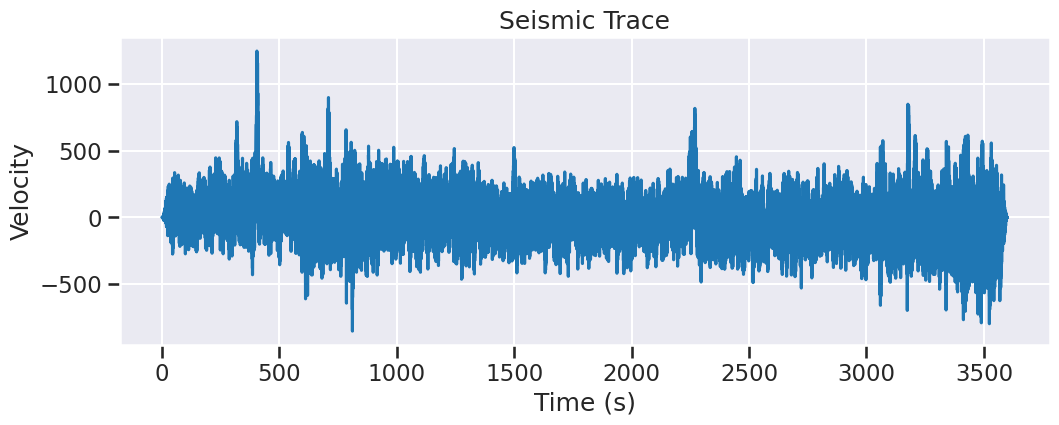

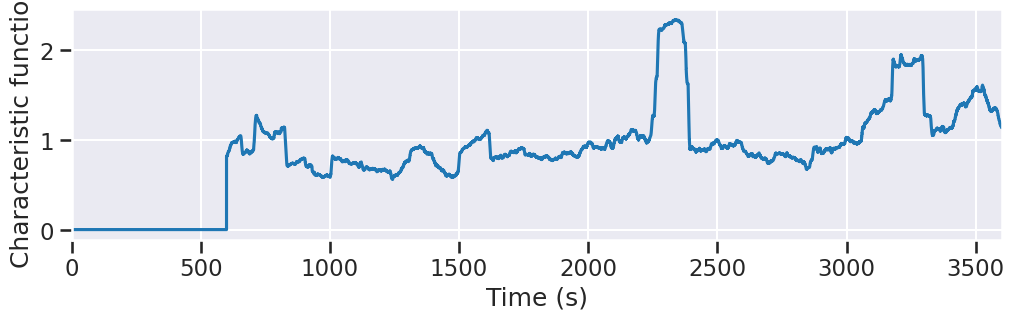

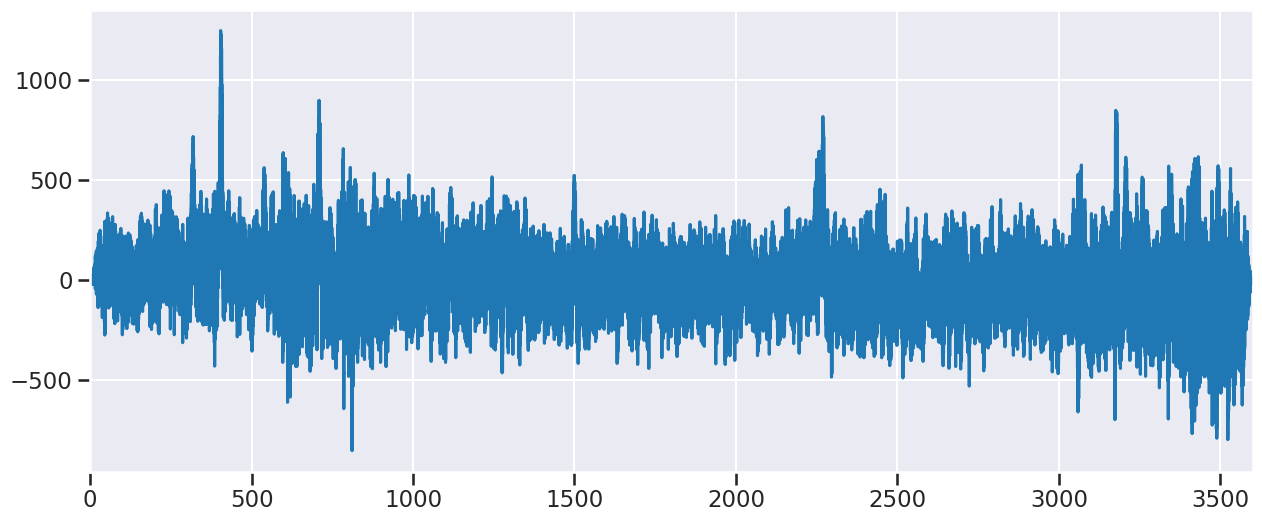

In [16]:
file_path = r'/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/mars/test/data/XB.ELYSE.02.BHV.2022-04-09HR22_evid0002.mseed'
st = read(file_path)
tr = st[0] 
tr_data = tr.data
tr_times = np.linspace(0, len(tr_data) / tr.stats.sampling_rate, num=len(tr_data))

plt.figure(figsize=(12, 4))
plt.plot(tr_times, tr_data)
plt.title('Seismic Trace')
plt.xlabel('Time (s)')
plt.ylabel('Velocity')
plt.show()
df = tr.stats.sampling_rate
sta_len = 120
lta_len = 600
cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,cft)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')
thr_on = 4
thr_off = 1.5
on_off = np.array(trigger_onset(cft, thr_on, thr_off))
fig,ax = plt.subplots(1,1,figsize=(15,6))
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    ax.axvline(x = tr_times[triggers[0]], color='red', label='Trig. On')
    print(f'Event detected at {tr_times[triggers[0]]}')
    ax.axvline(x = tr_times[triggers[1]], color='purple', label='Trig. Off')
ax.plot(tr_times,tr_data)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.legend()


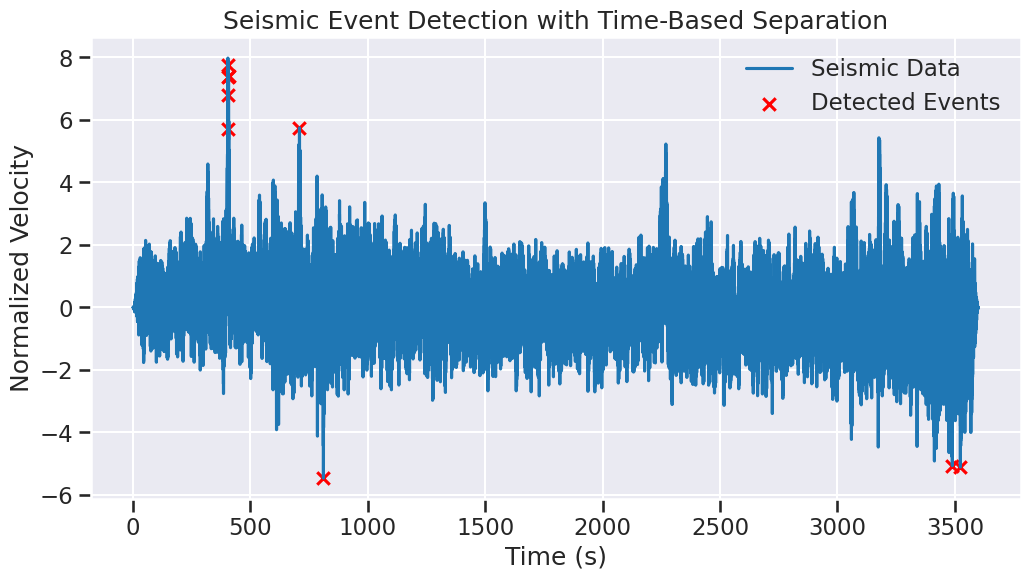

In [17]:
file_path = r'/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/mars/test/data/XB.ELYSE.02.BHV.2022-04-09HR22_evid0002.mseed'
st = read(file_path)
tr = st[0]  # Assuming only one trace for simplicity

# Extract data and timestamps
tr_data = tr.data
tr_times = np.linspace(0, len(tr_data) / tr.stats.sampling_rate, num=len(tr_data))

# Normalize the data (optional)
tr_data_norm = (tr_data - np.mean(tr_data)) / np.std(tr_data)

# Reshape the data for isolation forest (assuming each sample is a separate point)
data_points = tr_data_norm.reshape(-1, 1)

# Initialize Isolation Forest
#iso_forest = IsolationForest(contamination=0.0007, random_state=42)

# Fit the model on seismic data
#iso_forest.fit(data_points)

# Predict anomalies
anomalies = iso_forest.predict(data_points)

# Label anomalies as -1 and normal data as 1
anomalies_indices = np.where(anomalies == -1)[0]

# Threshold for event separation (in seconds)
min_separation_time = 1  # adjust this value based on your data's timescale
last_event_time = -np.inf  # initialize to negative infinity

filtered_anomalies_indices = []
for idx in anomalies_indices:
    if tr_times[idx] - last_event_time > min_separation_time:
        filtered_anomalies_indices.append(idx)
        last_event_time = tr_times[idx]  # update the last event time

filtered_anomalies_indices = np.array(filtered_anomalies_indices)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(tr_times, tr_data_norm, label='Seismic Data')
plt.scatter(tr_times[filtered_anomalies_indices], tr_data_norm[filtered_anomalies_indices], color='red', label='Detected Events', marker='x')
plt.title('Seismic Event Detection with Time-Based Separation')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Velocity')
plt.legend()
plt.show()

# Optionally, print the times where filtered anomalies were detected
event_times = tr_times[filtered_anomalies_indices]
#print("Filtered seismic events detected at times (s):", event_times)

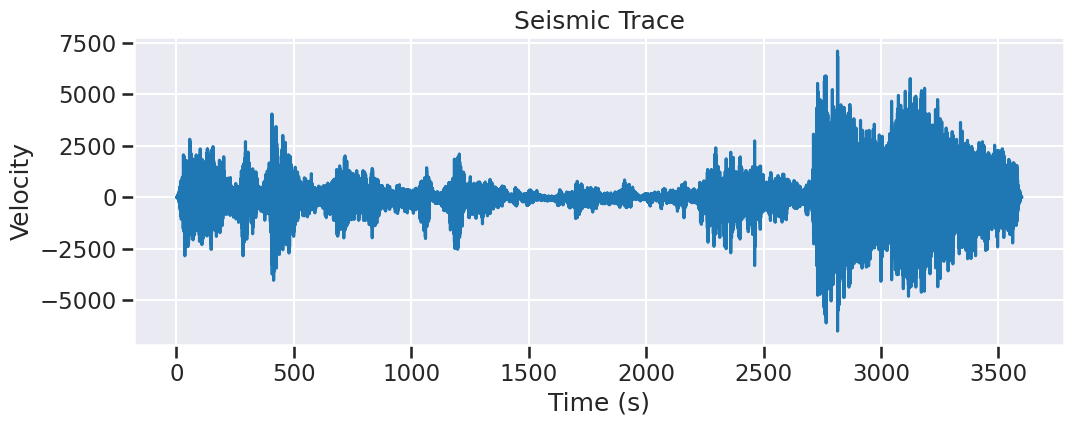

Event detected at 2825.639244989514


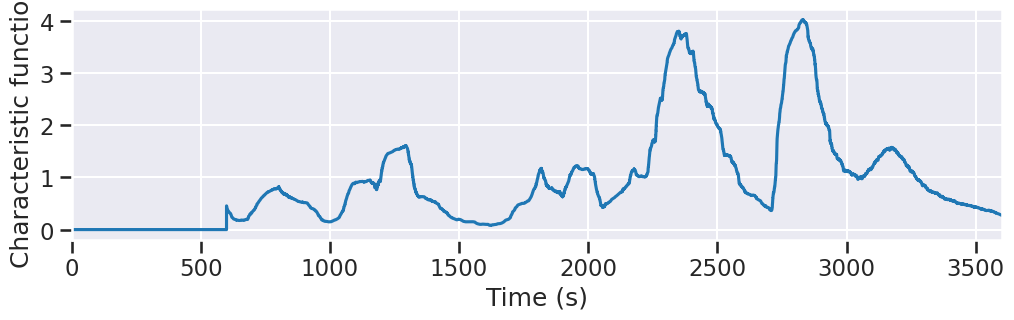

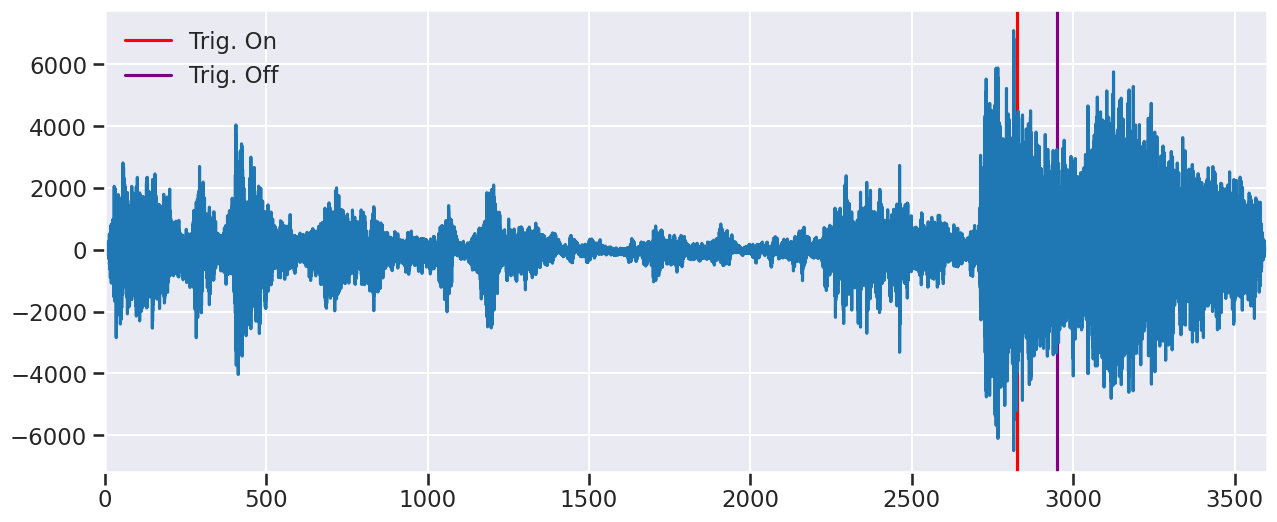

In [18]:
file_path = r'/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/mars/test/data/XB.ELYSE.02.BHV.2021-12-24HR22_evid0007.mseed'
st = read(file_path)
tr = st[0] 
tr_data = tr.data
tr_times = np.linspace(0, len(tr_data) / tr.stats.sampling_rate, num=len(tr_data))

plt.figure(figsize=(12, 4))
plt.plot(tr_times, tr_data)
plt.title('Seismic Trace')
plt.xlabel('Time (s)')
plt.ylabel('Velocity')
plt.show()
df = tr.stats.sampling_rate
sta_len = 120
lta_len = 600
cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,cft)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')
thr_on = 4
thr_off = 1.5
on_off = np.array(trigger_onset(cft, thr_on, thr_off))
fig,ax = plt.subplots(1,1,figsize=(15,6))
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    ax.axvline(x = tr_times[triggers[0]], color='red', label='Trig. On')
    print(f'Event detected at {tr_times[triggers[0]]}')
    ax.axvline(x = tr_times[triggers[1]], color='purple', label='Trig. Off')
ax.plot(tr_times,tr_data)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.legend()


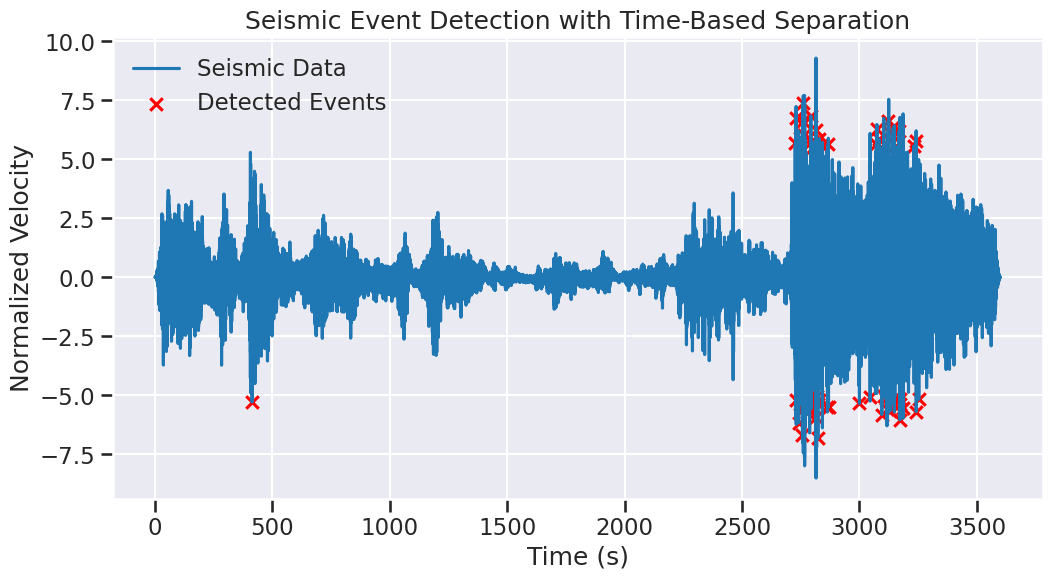

In [19]:
st = read(file_path)
tr = st[0]  # Assuming only one trace for simplicity

# Extract data and timestamps
tr_data = tr.data
tr_times = np.linspace(0, len(tr_data) / tr.stats.sampling_rate, num=len(tr_data))

# Normalize the data (optional)
tr_data_norm = (tr_data - np.mean(tr_data)) / np.std(tr_data)

# Reshape the data for isolation forest (assuming each sample is a separate point)
data_points = tr_data_norm.reshape(-1, 1)

# Initialize Isolation Forest
#iso_forest = IsolationForest(contamination=0.0007, random_state=42)

# Fit the model on seismic data
#iso_forest.fit(data_points)

# Predict anomalies
anomalies = iso_forest.predict(data_points)

# Label anomalies as -1 and normal data as 1
anomalies_indices = np.where(anomalies == -1)[0]

# Threshold for event separation (in seconds)
min_separation_time = 1  # adjust this value based on your data's timescale
last_event_time = -np.inf  # initialize to negative infinity

filtered_anomalies_indices = []
for idx in anomalies_indices:
    if tr_times[idx] - last_event_time > min_separation_time:
        filtered_anomalies_indices.append(idx)
        last_event_time = tr_times[idx]  # update the last event time

filtered_anomalies_indices = np.array(filtered_anomalies_indices)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(tr_times, tr_data_norm, label='Seismic Data')
plt.scatter(tr_times[filtered_anomalies_indices], tr_data_norm[filtered_anomalies_indices], color='red', label='Detected Events', marker='x')
plt.title('Seismic Event Detection with Time-Based Separation')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Velocity')
plt.legend()
plt.show()

# Optionally, print the times where filtered anomalies were detected
event_times = tr_times[filtered_anomalies_indices]
#print("Filtered seismic events detected at times (s):", event_times)

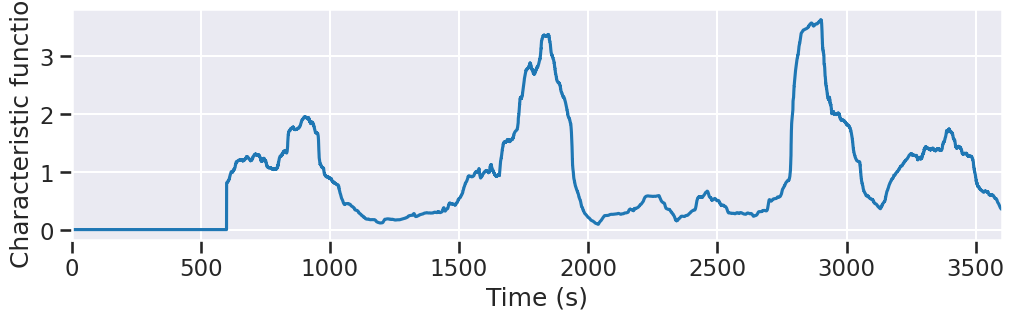

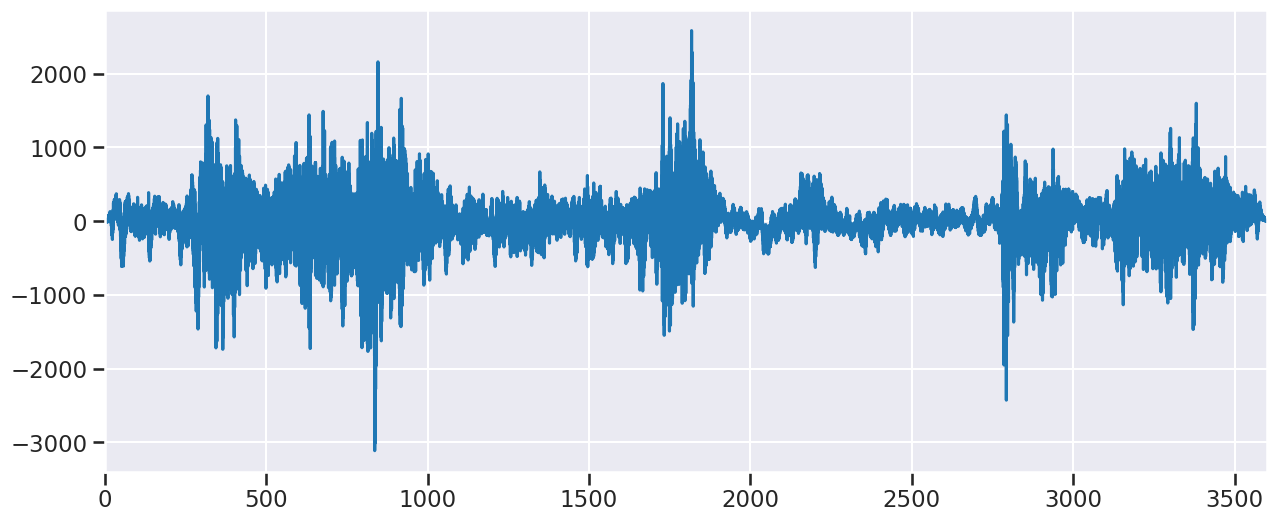

In [20]:
file_path = r'/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/mars/test/data/XB.ELYSE.02.BHV.2021-10-11HR23_evid0011.mseed'
st = read(file_path)
tr = st[0] 
tr_data = tr.data
tr_times = np.linspace(0, len(tr_data) / tr.stats.sampling_rate, num=len(tr_data))
df = tr.stats.sampling_rate
sta_len = 120
lta_len = 600
cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,cft)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')
thr_on = 4
thr_off = 1.5
on_off = np.array(trigger_onset(cft, thr_on, thr_off))
fig,ax = plt.subplots(1,1,figsize=(15,6))
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    ax.axvline(x = tr_times[triggers[0]], color='red', label='Trig. On')
    print(f'Event detected at {tr_times[triggers[0]]}')
    ax.axvline(x = tr_times[triggers[1]], color='purple', label='Trig. Off')
ax.plot(tr_times,tr_data)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.legend()


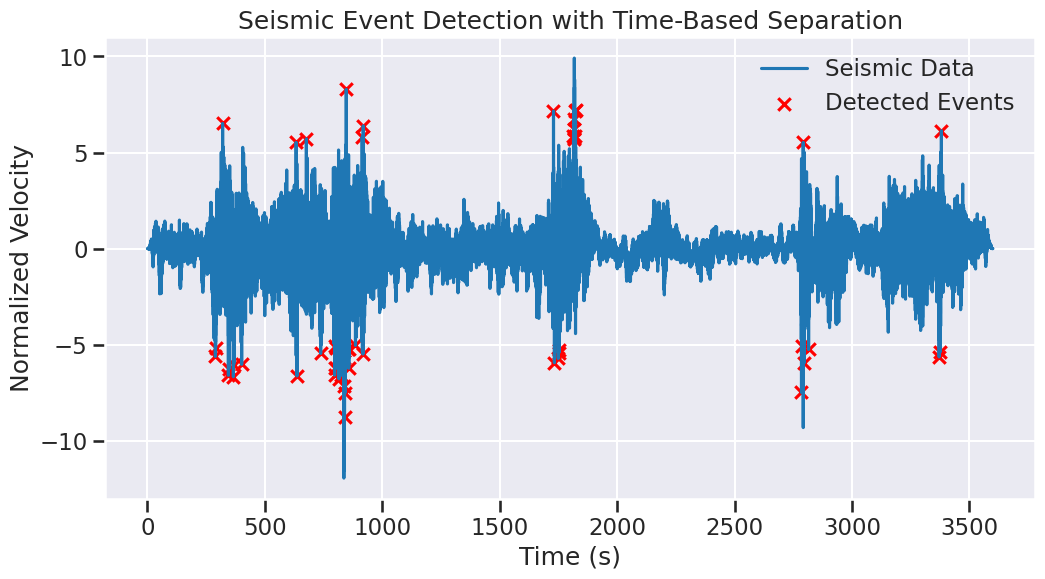

In [21]:
st = read(file_path)
tr = st[0]  # Assuming only one trace for simplicity

# Extract data and timestamps
tr_data = tr.data
tr_times = np.linspace(0, len(tr_data) / tr.stats.sampling_rate, num=len(tr_data))

# Normalize the data (optional)
tr_data_norm = (tr_data - np.mean(tr_data)) / np.std(tr_data)

# Reshape the data for isolation forest (assuming each sample is a separate point)
data_points = tr_data_norm.reshape(-1, 1)

# Initialize Isolation Forest
#iso_forest = IsolationForest(contamination=0.0007, random_state=42)

# Fit the model on seismic data
#iso_forest.fit(data_points)

# Predict anomalies
anomalies = iso_forest.predict(data_points)

# Label anomalies as -1 and normal data as 1
anomalies_indices = np.where(anomalies == -1)[0]

# Threshold for event separation (in seconds)
min_separation_time = 1  # adjust this value based on your data's timescale
last_event_time = -np.inf  # initialize to negative infinity

filtered_anomalies_indices = []
for idx in anomalies_indices:
    if tr_times[idx] - last_event_time > min_separation_time:
        filtered_anomalies_indices.append(idx)
        last_event_time = tr_times[idx]  # update the last event time

filtered_anomalies_indices = np.array(filtered_anomalies_indices)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(tr_times, tr_data_norm, label='Seismic Data')
plt.scatter(tr_times[filtered_anomalies_indices], tr_data_norm[filtered_anomalies_indices], color='red', label='Detected Events', marker='x')
plt.title('Seismic Event Detection with Time-Based Separation')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Velocity')
plt.legend()
plt.show()

# Optionally, print the times where filtered anomalies were detected
event_times = tr_times[filtered_anomalies_indices]
#print("Filtered seismic events detected at times (s):", event_times)

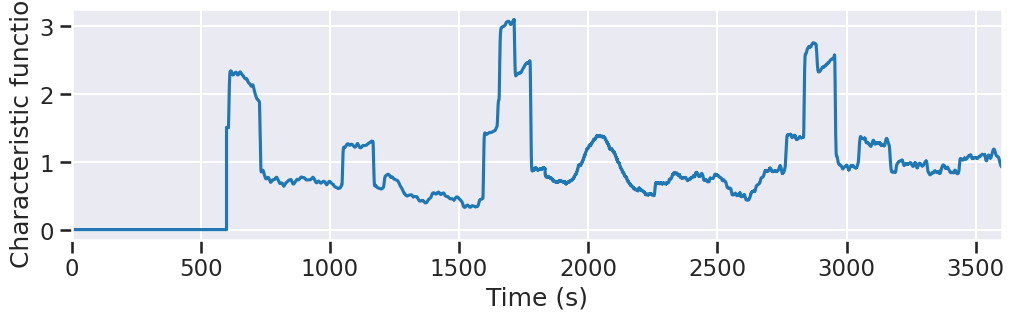

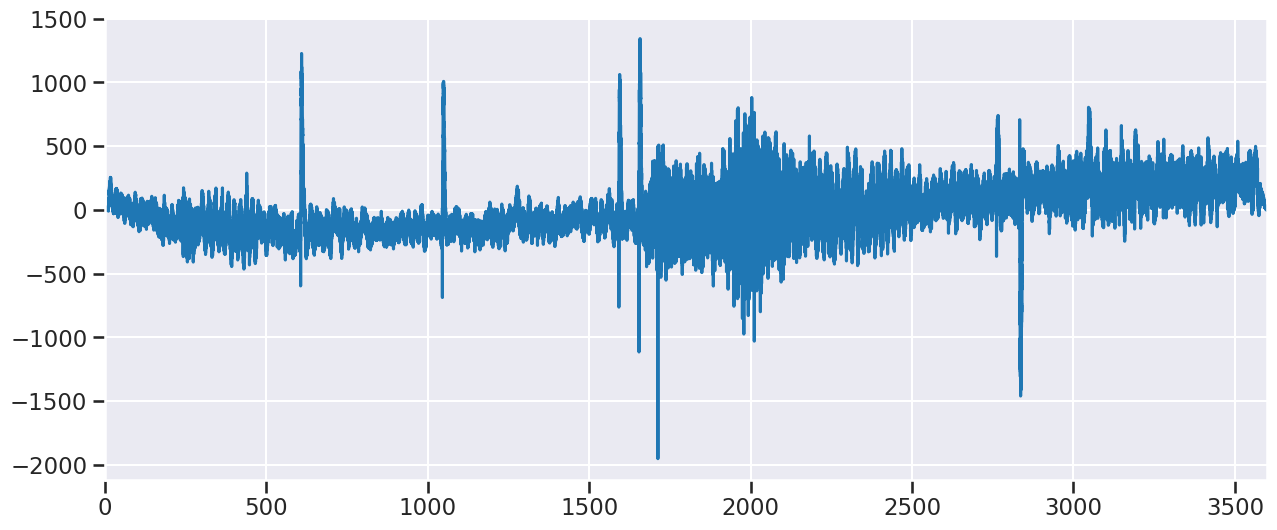

In [22]:
file_path = r'/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/mars/test/data/XB.ELYSE.02.BHV.2021-05-02HR01_evid0017.mseed'
st = read(file_path)
tr = st[0] 
tr_data = tr.data
tr_times = np.linspace(0, len(tr_data) / tr.stats.sampling_rate, num=len(tr_data))
df = tr.stats.sampling_rate
sta_len = 120
lta_len = 600
cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,cft)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')
thr_on = 4
thr_off = 1.5
on_off = np.array(trigger_onset(cft, thr_on, thr_off))
fig,ax = plt.subplots(1,1,figsize=(15,6))
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    ax.axvline(x = tr_times[triggers[0]], color='red', label='Trig. On')
    print(f'Event detected at {tr_times[triggers[0]]}')
    ax.axvline(x = tr_times[triggers[1]], color='purple', label='Trig. Off')
ax.plot(tr_times,tr_data)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.legend()


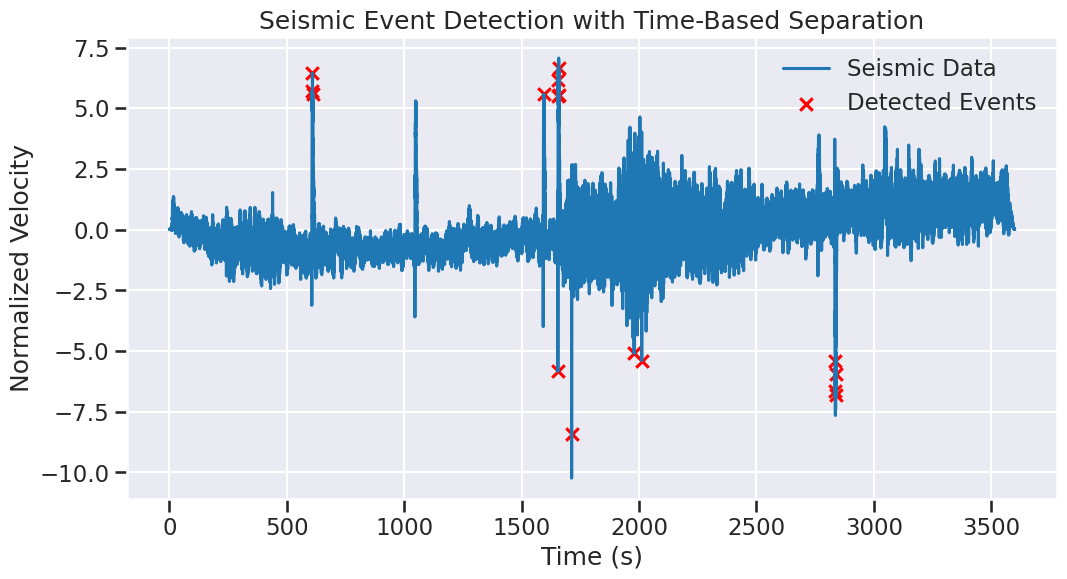

In [23]:
st = read(file_path)
tr = st[0]  # Assuming only one trace for simplicity

# Extract data and timestamps
tr_data = tr.data
tr_times = np.linspace(0, len(tr_data) / tr.stats.sampling_rate, num=len(tr_data))

# Normalize the data (optional)
tr_data_norm = (tr_data - np.mean(tr_data)) / np.std(tr_data)

# Reshape the data for isolation forest (assuming each sample is a separate point)
data_points = tr_data_norm.reshape(-1, 1)

# Initialize Isolation Forest
#iso_forest = IsolationForest(contamination=0.0007, random_state=42)

# Fit the model on seismic data
#iso_forest.fit(data_points)

# Predict anomalies
anomalies = iso_forest.predict(data_points)

# Label anomalies as -1 and normal data as 1
anomalies_indices = np.where(anomalies == -1)[0]

# Threshold for event separation (in seconds)
min_separation_time = 1  # adjust this value based on your data's timescale
last_event_time = -np.inf  # initialize to negative infinity

filtered_anomalies_indices = []
for idx in anomalies_indices:
    if tr_times[idx] - last_event_time > min_separation_time:
        filtered_anomalies_indices.append(idx)
        last_event_time = tr_times[idx]  # update the last event time

filtered_anomalies_indices = np.array(filtered_anomalies_indices)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(tr_times, tr_data_norm, label='Seismic Data')
plt.scatter(tr_times[filtered_anomalies_indices], tr_data_norm[filtered_anomalies_indices], color='red', label='Detected Events', marker='x')
plt.title('Seismic Event Detection with Time-Based Separation')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Velocity')
plt.legend()
plt.show()

# Optionally, print the times where filtered anomalies were detected
event_times = tr_times[filtered_anomalies_indices]
#print("Filtered seismic events detected at times (s):", event_times)

Event detected at 2272.48156224392


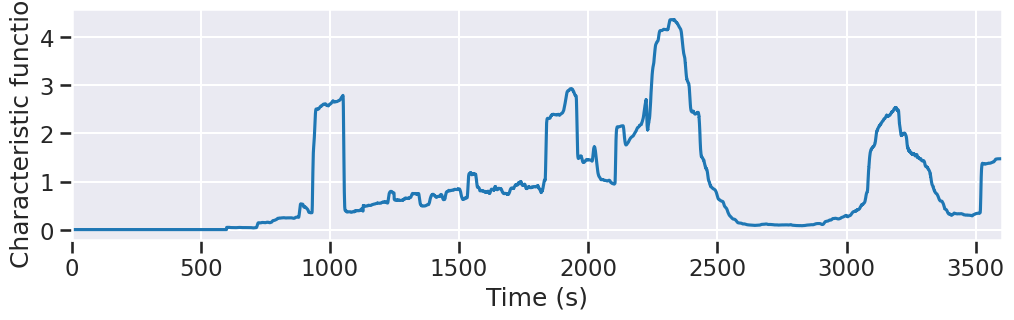

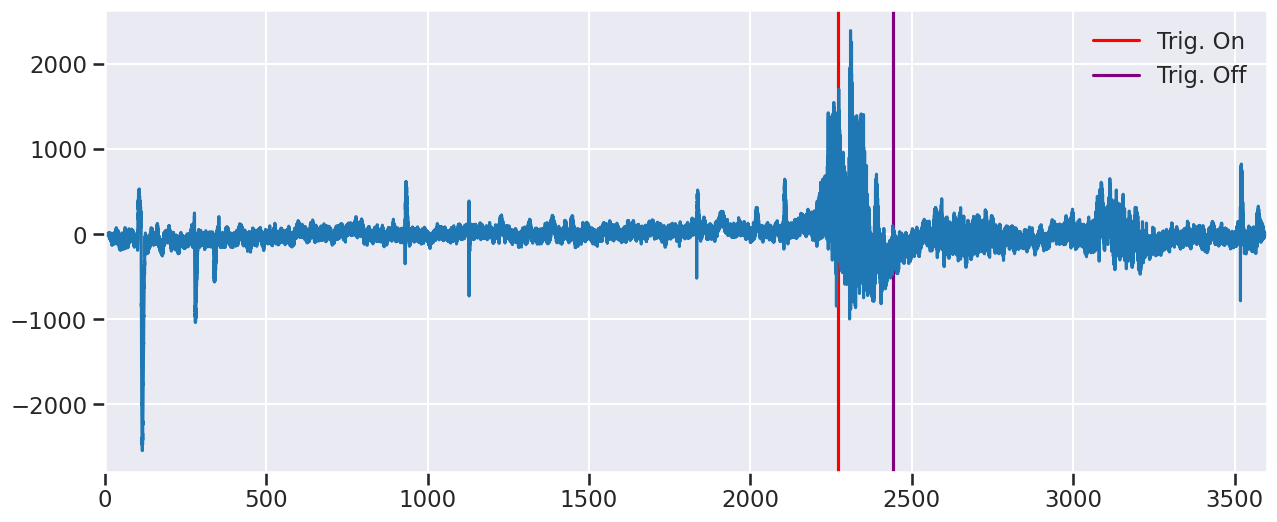

In [24]:
file_path = r'/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/mars/test/data/XB.ELYSE.02.BHV.2019-09-21HR03_evid0032.mseed'
st = read(file_path)
tr = st[0] 
tr_data = tr.data
tr_times = np.linspace(0, len(tr_data) / tr.stats.sampling_rate, num=len(tr_data))
df = tr.stats.sampling_rate
sta_len = 120
lta_len = 600
cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,cft)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')
thr_on = 4
thr_off = 1.5
on_off = np.array(trigger_onset(cft, thr_on, thr_off))
fig,ax = plt.subplots(1,1,figsize=(15,6))
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    ax.axvline(x = tr_times[triggers[0]], color='red', label='Trig. On')
    print(f'Event detected at {tr_times[triggers[0]]}')
    ax.axvline(x = tr_times[triggers[1]], color='purple', label='Trig. Off')
ax.plot(tr_times,tr_data)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.legend()


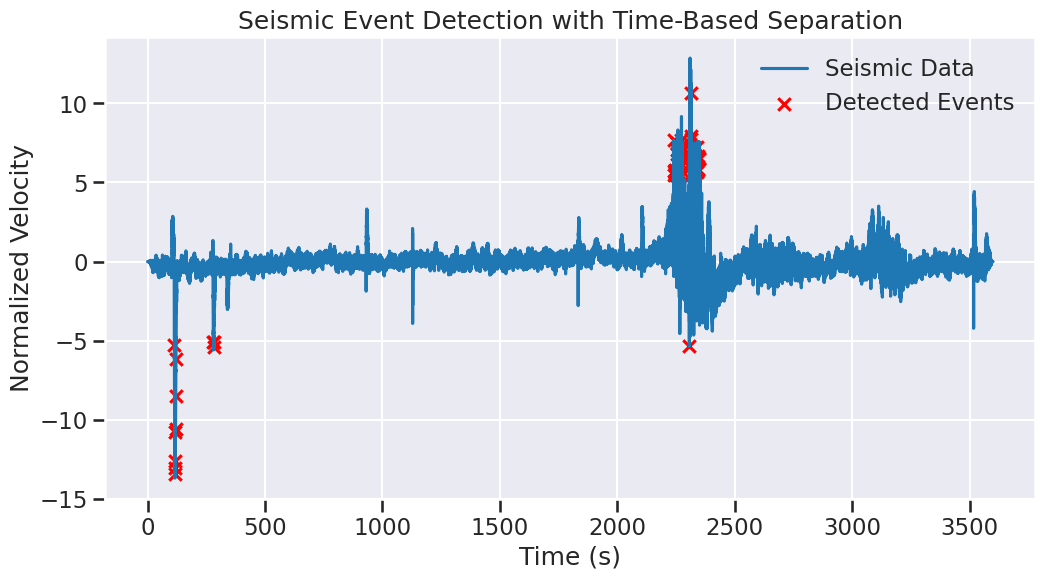

In [25]:
st = read(file_path)
tr = st[0]  # Assuming only one trace for simplicity

# Extract data and timestamps
tr_data = tr.data
tr_times = np.linspace(0, len(tr_data) / tr.stats.sampling_rate, num=len(tr_data))

# Normalize the data (optional)
tr_data_norm = (tr_data - np.mean(tr_data)) / np.std(tr_data)

# Reshape the data for isolation forest (assuming each sample is a separate point)
data_points = tr_data_norm.reshape(-1, 1)

# Initialize Isolation Forest
#iso_forest = IsolationForest(contamination=0.0007, random_state=42)

# Fit the model on seismic data
#iso_forest.fit(data_points)

# Predict anomalies
anomalies = iso_forest.predict(data_points)

# Label anomalies as -1 and normal data as 1
anomalies_indices = np.where(anomalies == -1)[0]

# Threshold for event separation (in seconds)
min_separation_time = 1  # adjust this value based on your data's timescale
last_event_time = -np.inf  # initialize to negative infinity

filtered_anomalies_indices = []
for idx in anomalies_indices:
    if tr_times[idx] - last_event_time > min_separation_time:
        filtered_anomalies_indices.append(idx)
        last_event_time = tr_times[idx]  # update the last event time

filtered_anomalies_indices = np.array(filtered_anomalies_indices)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(tr_times, tr_data_norm, label='Seismic Data')
plt.scatter(tr_times[filtered_anomalies_indices], tr_data_norm[filtered_anomalies_indices], color='red', label='Detected Events', marker='x')
plt.title('Seismic Event Detection with Time-Based Separation')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Velocity')
plt.legend()
plt.show()

# Optionally, print the times where filtered anomalies were detected
event_times = tr_times[filtered_anomalies_indices]
#print("Filtered seismic events detected at times (s):", event_times)

Event detected at 757.0605147293712
Event detected at 3251.1451547938163


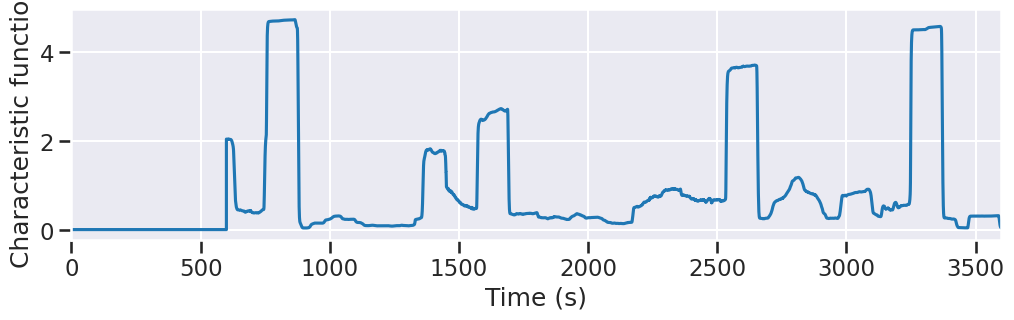

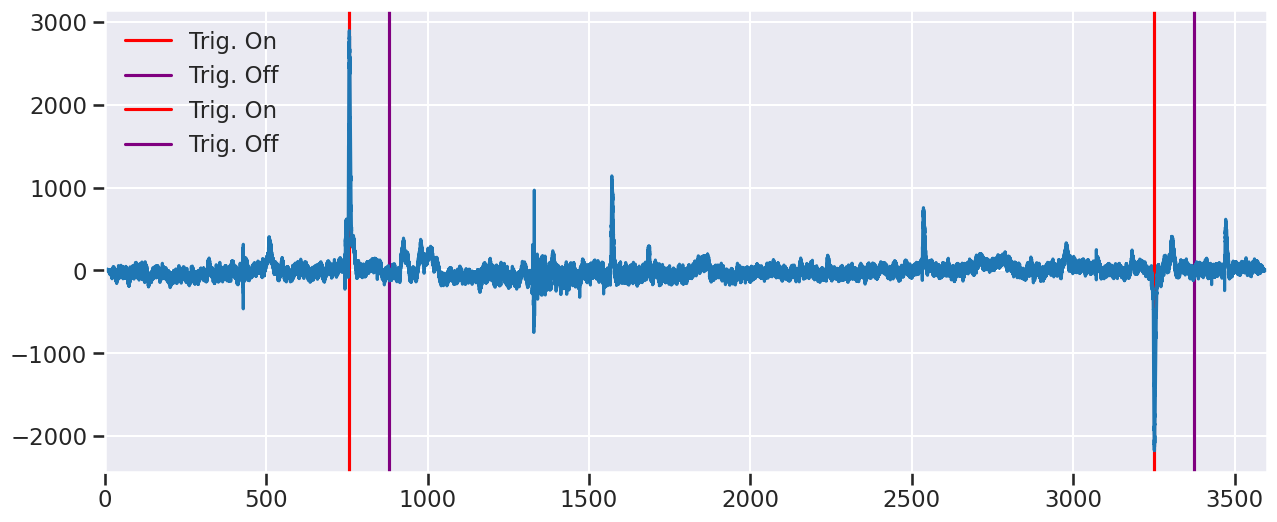

In [26]:
file_path = r'/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/mars/test/data/XB.ELYSE.02.BHV.2019-07-26HR12_evid0034.mseed'
st = read(file_path)
tr = st[0] 
tr_data = tr.data
tr_times = np.linspace(0, len(tr_data) / tr.stats.sampling_rate, num=len(tr_data))
df = tr.stats.sampling_rate
sta_len = 120
lta_len = 600
cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,cft)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')
thr_on = 4
thr_off = 1.5
on_off = np.array(trigger_onset(cft, thr_on, thr_off))
fig,ax = plt.subplots(1,1,figsize=(15,6))
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    ax.axvline(x = tr_times[triggers[0]], color='red', label='Trig. On')
    print(f'Event detected at {tr_times[triggers[0]]}')
    ax.axvline(x = tr_times[triggers[1]], color='purple', label='Trig. Off')
ax.plot(tr_times,tr_data)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.legend()


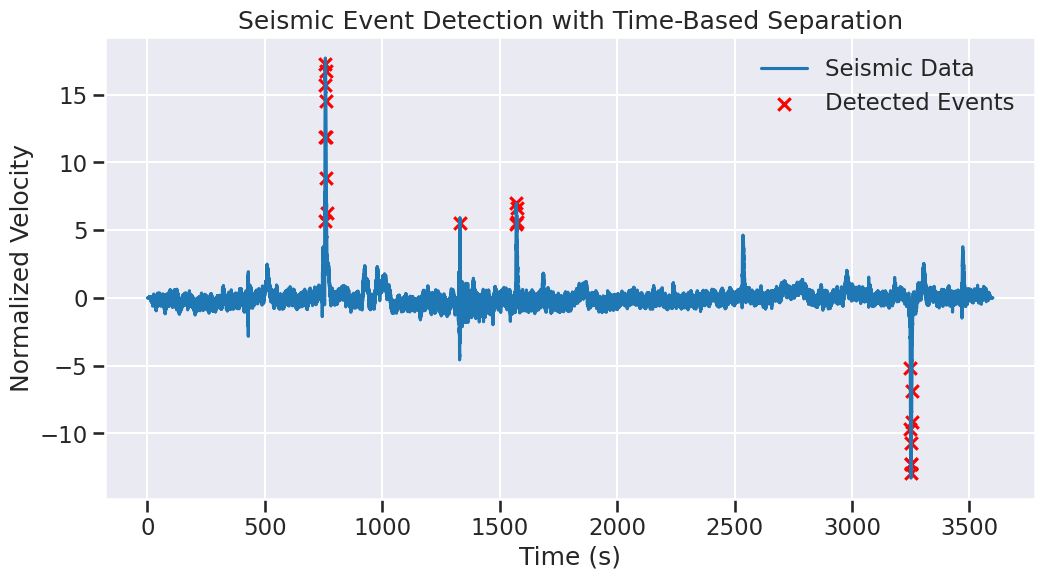

In [27]:
st = read(file_path)
tr = st[0]  # Assuming only one trace for simplicity

# Extract data and timestamps
tr_data = tr.data
tr_times = np.linspace(0, len(tr_data) / tr.stats.sampling_rate, num=len(tr_data))

# Normalize the data (optional)
tr_data_norm = (tr_data - np.mean(tr_data)) / np.std(tr_data)

# Reshape the data for isolation forest (assuming each sample is a separate point)
data_points = tr_data_norm.reshape(-1, 1)

# Initialize Isolation Forest
#iso_forest = IsolationForest(contamination=0.0007, random_state=42)

# Fit the model on seismic data
#iso_forest.fit(data_points)

# Predict anomalies
anomalies = iso_forest.predict(data_points)

# Label anomalies as -1 and normal data as 1
anomalies_indices = np.where(anomalies == -1)[0]

# Threshold for event separation (in seconds)
min_separation_time = 1  # adjust this value based on your data's timescale
last_event_time = -np.inf  # initialize to negative infinity

filtered_anomalies_indices = []
for idx in anomalies_indices:
    if tr_times[idx] - last_event_time > min_separation_time:
        filtered_anomalies_indices.append(idx)
        last_event_time = tr_times[idx]  # update the last event time

filtered_anomalies_indices = np.array(filtered_anomalies_indices)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(tr_times, tr_data_norm, label='Seismic Data')
plt.scatter(tr_times[filtered_anomalies_indices], tr_data_norm[filtered_anomalies_indices], color='red', label='Detected Events', marker='x')
plt.title('Seismic Event Detection with Time-Based Separation')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Velocity')
plt.legend()
plt.show()

# Optionally, print the times where filtered anomalies were detected
event_times = tr_times[filtered_anomalies_indices]
#print("Filtered seismic events detected at times (s):", event_times)

Event detected at 757.0605147293712
Event detected at 3251.1451547938163


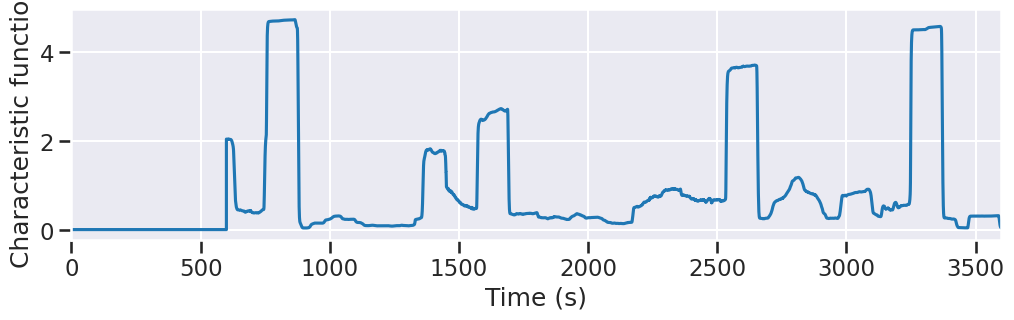

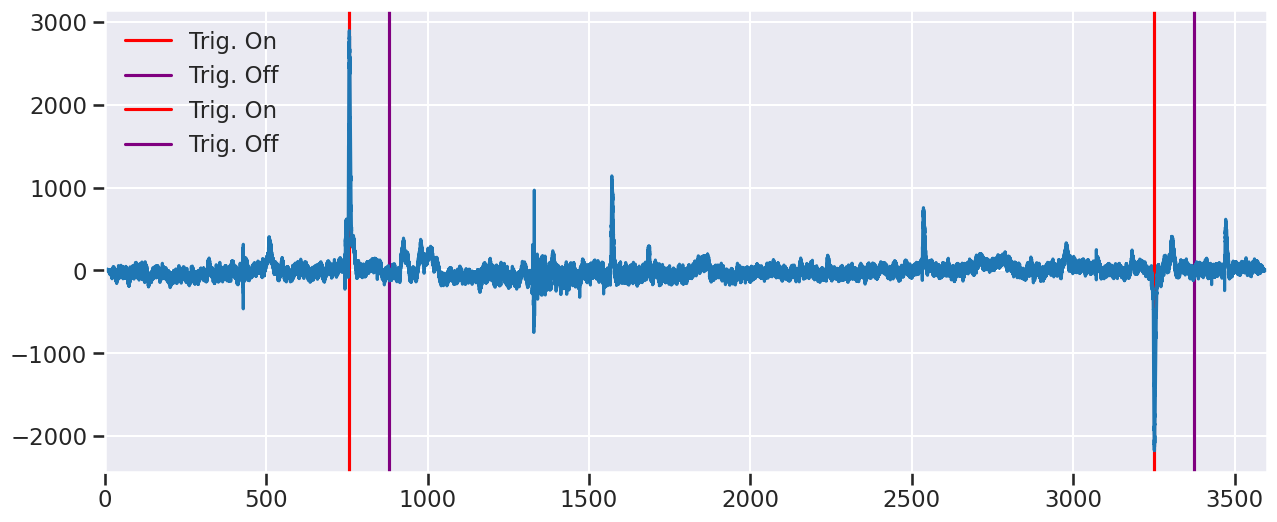

In [28]:
file_path = r'/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/mars/test/data/XB.ELYSE.02.BHV.2019-07-26HR12_evid0033.mseed'
st = read(file_path)
tr = st[0] 
tr_data = tr.data
tr_times = np.linspace(0, len(tr_data) / tr.stats.sampling_rate, num=len(tr_data))
df = tr.stats.sampling_rate
sta_len = 120
lta_len = 600
cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,cft)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')
thr_on = 4
thr_off = 1.5
on_off = np.array(trigger_onset(cft, thr_on, thr_off))
fig,ax = plt.subplots(1,1,figsize=(15,6))
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    ax.axvline(x = tr_times[triggers[0]], color='red', label='Trig. On')
    print(f'Event detected at {tr_times[triggers[0]]}')
    ax.axvline(x = tr_times[triggers[1]], color='purple', label='Trig. Off')
ax.plot(tr_times,tr_data)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.legend()


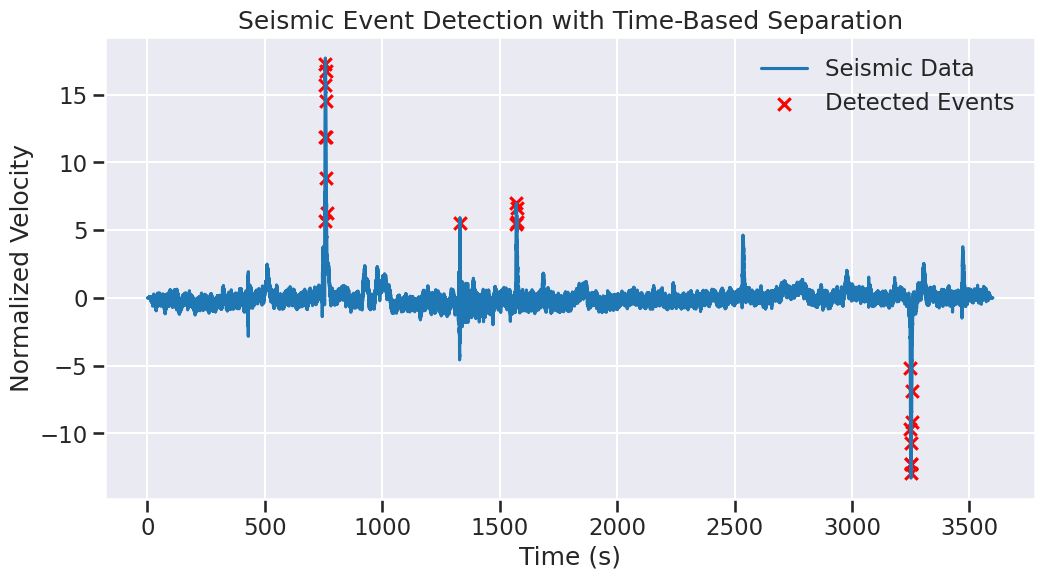

Filtered seismic events detected at times (s): [ 754.81048348  755.81049737  756.81051126  757.81052515  758.81053904
  759.81055292  760.81056681  761.8105807   762.81059459 1330.61848081
 1569.72180169 1570.72181558 1571.72182947 1572.72184336 3247.99511104
 3248.99512493 3249.99513882 3250.99515271 3251.9951666  3252.99518049
 3253.99519438 3254.99520827]


In [29]:
st = read(file_path)
tr = st[0]  # Assuming only one trace for simplicity

# Extract data and timestamps
tr_data = tr.data
tr_times = np.linspace(0, len(tr_data) / tr.stats.sampling_rate, num=len(tr_data))

# Normalize the data (optional)
tr_data_norm = (tr_data - np.mean(tr_data)) / np.std(tr_data)

# Reshape the data for isolation forest (assuming each sample is a separate point)
data_points = tr_data_norm.reshape(-1, 1)

# Initialize Isolation Forest
#iso_forest = IsolationForest(contamination=0.0007, random_state=42)

# Fit the model on seismic data
#iso_forest.fit(data_points)

# Predict anomalies
anomalies = iso_forest.predict(data_points)

# Label anomalies as -1 and normal data as 1
anomalies_indices = np.where(anomalies == -1)[0]

# Threshold for event separation (in seconds)
min_separation_time = 1  # adjust this value based on your data's timescale
last_event_time = -np.inf  # initialize to negative infinity

filtered_anomalies_indices = []
for idx in anomalies_indices:
    if tr_times[idx] - last_event_time > min_separation_time:
        filtered_anomalies_indices.append(idx)
        last_event_time = tr_times[idx]  # update the last event time

filtered_anomalies_indices = np.array(filtered_anomalies_indices)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(tr_times, tr_data_norm, label='Seismic Data')
plt.scatter(tr_times[filtered_anomalies_indices], tr_data_norm[filtered_anomalies_indices], color='red', label='Detected Events', marker='x')
plt.title('Seismic Event Detection with Time-Based Separation')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Velocity')
plt.legend()
plt.show()

# Optionally, print the times where filtered anomalies were detected
event_times = tr_times[filtered_anomalies_indices]
print("Filtered seismic events detected at times (s):", event_times)

Event detected at 2291.6318282198363


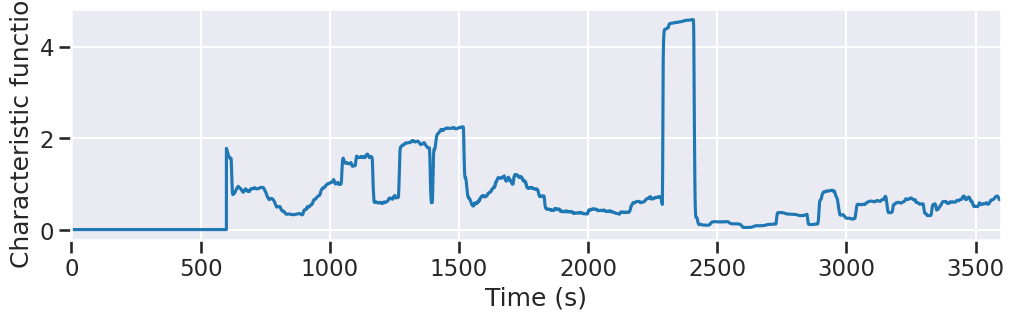

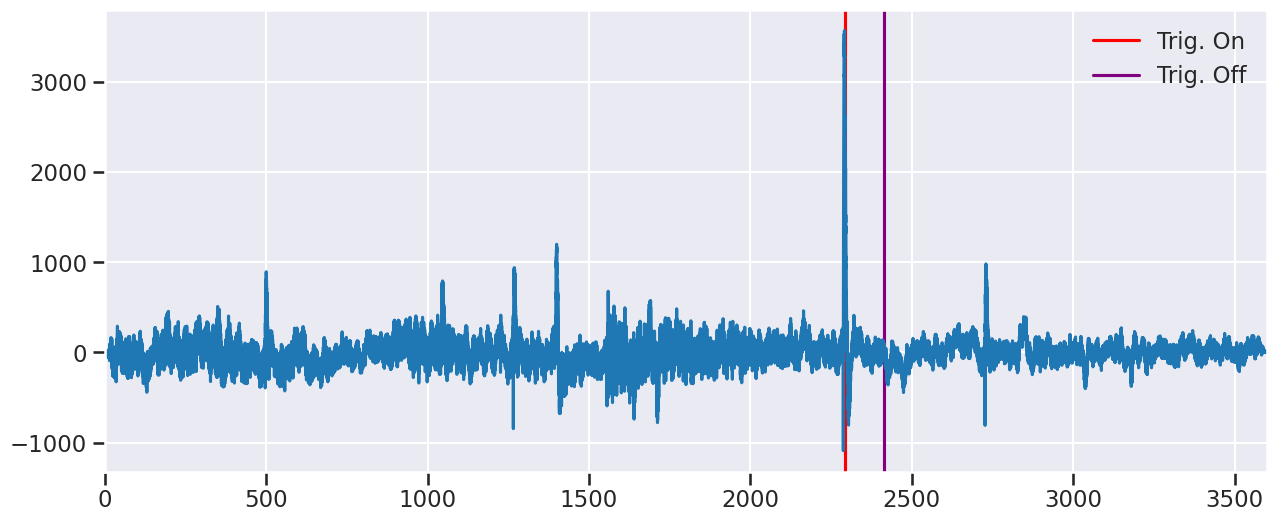

In [30]:
file_path = r'/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/mars/test/data/XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.mseed'
st = read(file_path)
tr = st[0] 
tr_data = tr.data
tr_times = np.linspace(0, len(tr_data) / tr.stats.sampling_rate, num=len(tr_data))
df = tr.stats.sampling_rate
sta_len = 120
lta_len = 600
cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,cft)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')
thr_on = 4
thr_off = 1.5
on_off = np.array(trigger_onset(cft, thr_on, thr_off))
fig,ax = plt.subplots(1,1,figsize=(15,6))
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    ax.axvline(x = tr_times[triggers[0]], color='red', label='Trig. On')
    print(f'Event detected at {tr_times[triggers[0]]}')
    ax.axvline(x = tr_times[triggers[1]], color='purple', label='Trig. Off')
ax.plot(tr_times,tr_data)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.legend()


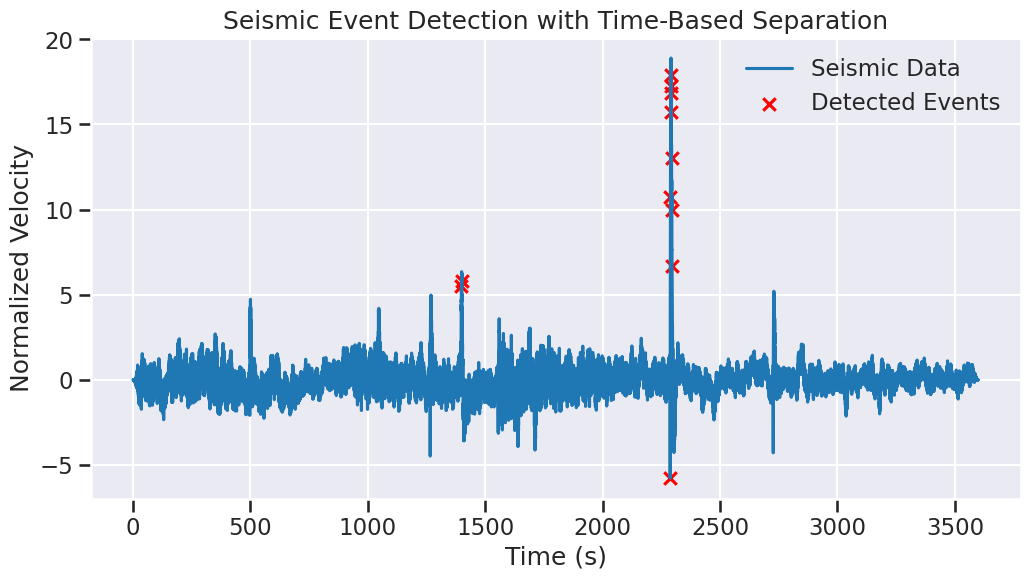

In [31]:
st = read(file_path)
tr = st[0]  # Assuming only one trace for simplicity

# Extract data and timestamps
tr_data = tr.data
tr_times = np.linspace(0, len(tr_data) / tr.stats.sampling_rate, num=len(tr_data))

# Normalize the data (optional)
tr_data_norm = (tr_data - np.mean(tr_data)) / np.std(tr_data)

# Reshape the data for isolation forest (assuming each sample is a separate point)
data_points = tr_data_norm.reshape(-1, 1)

# Initialize Isolation Forest
#iso_forest = IsolationForest(contamination=0.0007, random_state=42)

# Fit the model on seismic data
#iso_forest.fit(data_points)

# Predict anomalies
anomalies = iso_forest.predict(data_points)

# Label anomalies as -1 and normal data as 1
anomalies_indices = np.where(anomalies == -1)[0]

# Threshold for event separation (in seconds)
min_separation_time = 1  # adjust this value based on your data's timescale
last_event_time = -np.inf  # initialize to negative infinity

filtered_anomalies_indices = []
for idx in anomalies_indices:
    if tr_times[idx] - last_event_time > min_separation_time:
        filtered_anomalies_indices.append(idx)
        last_event_time = tr_times[idx]  # update the last event time

filtered_anomalies_indices = np.array(filtered_anomalies_indices)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(tr_times, tr_data_norm, label='Seismic Data')
plt.scatter(tr_times[filtered_anomalies_indices], tr_data_norm[filtered_anomalies_indices], color='red', label='Detected Events', marker='x')
plt.title('Seismic Event Detection with Time-Based Separation')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Velocity')
plt.legend()
plt.show()

# Optionally, print the times where filtered anomalies were detected
event_times = tr_times[filtered_anomalies_indices]
#print("Filtered seismic events detected at times (s):", event_times)